In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\7420\AppData\Local\Temp\ipykernel_6720\4002754608.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0.           1.69491525   3.38983051   5.08474576   6.77966102
   8.47457627  10.16949153  11.86440678  13.55932203  15.25423729
  16.94915254  18.6440678   20.33898305  22.03389831  23.72881356
  25.42372881  27.11864407  28.81355932  30.50847458  32.20338983
  33.89830508  35.59322034  37.28813559  38.98305085  40.6779661
  42.37288136  44.06779661  45.76271186  47.45762712  49.15254237
  50.84745763  52.54237288  54.23728814  55.93220339  57.62711864
  59.3220339   61.01694915  62.71186441  64.40677966  66.10169492
  67.79661017  69.49152542  71.18644068  72.88135593  74.57627119
  76.27118644  77.96610169  79.66101695  81.3559322   83.05084746
  84.74576271  86.44067797  88.13559322  89.83050847  91.52542373
  93.22033898  94.91525424  96.61016949  98.30508475 100.        ]' has dtype incompatible 

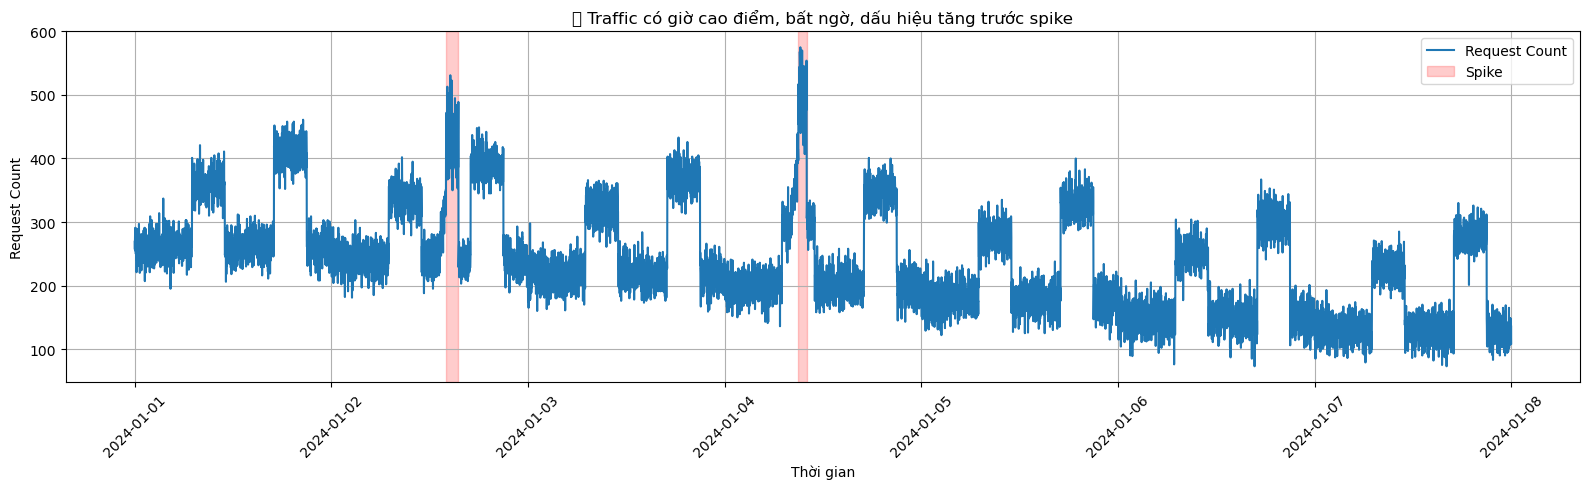

In [38]:
minutes = 60 * 24 * 7
timestamps = pd.date_range("2024-01-01", periods=minutes, freq="T")
df = pd.DataFrame({"Timestamp": timestamps})
df["Hour"] = df["Timestamp"].dt.hour
df["Weekday"] = df["Timestamp"].dt.dayofweek

# --- 2. Traffic cơ bản theo giờ/ngày ---
base = 180
df["HourBoost"] = 0
df.loc[df["Hour"].between(7, 10), "HourBoost"] += 100
df.loc[df["Hour"].between(17, 20), "HourBoost"] += 150

weekday_boost = {
    0: 80, 1: 60, 2: 40, 3: 20, 4: 0, 5: -30, 6: -50
}
df["WeekdayBoost"] = df["Weekday"].map(weekday_boost)

# --- 3. Noise: traffic không đều ---
np.random.seed(42)
df["Noise"] = np.random.normal(0, 20, size=len(df))

# --- 4. Một số spike đột biến có dấu hiệu tăng trước ---
df["Spike"] = 0
spike_times = [
    ("2024-01-02 14:00", "2024-01-02 15:30"),
    ("2024-01-04 09:00", "2024-01-04 10:00")
]
for start, end in spike_times:
    spike_range = (df["Timestamp"] >= start) & (df["Timestamp"] <= end)
    lead_range = (df["Timestamp"] >= pd.to_datetime(start) - pd.Timedelta(minutes=60)) & (df["Timestamp"] < start)
    
    # tăng dần trước spike
    df.loc[lead_range, "Spike"] += np.linspace(0, 100, lead_range.sum())
    # spike thật sự
    df.loc[spike_range, "Spike"] += 200 + np.random.normal(0, 30, spike_range.sum())

# --- 5. Tổng hợp request count ---
df["Request Count"] = (
    base +
    df["HourBoost"] +
    df["WeekdayBoost"] +
    df["Noise"] +
    df["Spike"]
).clip(lower=0).astype(int)

# --- 6. Vẽ kết quả ---
plt.figure(figsize=(16, 5))
subset = df
plt.plot(subset["Timestamp"], subset["Request Count"], label="Request Count", color="tab:blue")

# highlight spike
for start, end in spike_times:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.2, label='Spike' if start == spike_times[0][0] else "")

plt.title("📊 Traffic có giờ cao điểm, bất ngờ, dấu hiệu tăng trước spike")
plt.xlabel("Thời gian")
plt.ylabel("Request Count")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
df_raw = pd.read_csv("../../data/mock-metrics/1.csv", sep=";")
df_raw.head()

,Timestamp [ms],\tCPU cores,\tCPU capacity provisioned [MHZ],\tCPU usage [MHZ],\tCPU usage [%],\tMemory capacity provisioned [KB],\tMemory usage [KB],\tDisk read throughput [KB/s],\tDisk write throughput [KB/s],\tNetwork received throughput [KB/s],\tNetwork transmitted throughput [KB/s]
0,1376314846,4,11703.99824,10912.027692,93.233333,67108864.0,6.129274e+06,0.133333,15981.600000,0.000000,2.133333
1,1376315146,4,11703.99824,10890.570362,93.050000,67108864.0,6.755624e+06,1.333333,19137.333333,0.000000,2.600000
2,1376315446,4,11703.99824,10434.114431,89.150000,67108864.0,8.947846e+06,2.533333,19974.933333,535.666667,23.933333
3,1376315746,4,11703.99824,10539.450415,90.050000,67108864.0,1.879048e+07,5.466667,8791.800000,349.666667,5.466667
4,1376316046,4,11703.99824,10951.041020,93.566667,67108864.0,9.305761e+06,5.400000,15679.533333,0.000000,2.066667


In [39]:
import numpy as np
import pandas as pd

np.random.seed(42)

minutes = 60 * 24 * 7
timestamps = pd.date_range("2024-01-01", periods=minutes, freq="T")
df = pd.DataFrame({"Timestamp": timestamps})
df["Hour"] = df["Timestamp"].dt.hour
df["Weekday"] = df["Timestamp"].dt.dayofweek

# --- Traffic cơ bản request count như trước ---
base = 180
df["HourBoost"] = 0
df.loc[df["Hour"].between(7, 10), "HourBoost"] += 100
df.loc[df["Hour"].between(17, 20), "HourBoost"] += 150

weekday_boost = {0: 80, 1: 60, 2: 40, 3: 20, 4: 0, 5: -30, 6: -50}
df["WeekdayBoost"] = df["Weekday"].map(weekday_boost)

df["Noise"] = np.random.normal(0, 20, size=len(df))

df["Spike"] = 0
spike_times = [
    ("2024-01-02 14:00", "2024-01-02 15:30"),
    ("2024-01-04 09:00", "2024-01-04 10:00")
]
for start, end in spike_times:
    spike_range = (df["Timestamp"] >= start) & (df["Timestamp"] <= end)
    lead_range = (df["Timestamp"] >= pd.to_datetime(start) - pd.Timedelta(minutes=60)) & (df["Timestamp"] < start)
    df.loc[lead_range, "Spike"] += np.linspace(0, 100, lead_range.sum())
    df.loc[spike_range, "Spike"] += 200 + np.random.normal(0, 30, spike_range.sum())

df["Request Count"] = (base + df["HourBoost"] + df["WeekdayBoost"] + df["Noise"] + df["Spike"]).clip(lower=0).astype(int)

# --- Tạo các metrics hệ thống giả lập dựa trên Request Count ---
# CPU cores, giả sử 4 cores
df["CPU cores"] = 4

# CPU capacity provisioned (MHZ), ví dụ 4 cores x 3000 MHz mỗi core
df["CPU capacity provisioned [MHZ]"] = 4 * 3000

# CPU usage (MHZ), tỷ lệ CPU dùng theo request count biến động
cpu_usage_base = df["Request Count"] * 10 + np.random.normal(0, 50, size=len(df))
# Giới hạn không vượt quá capacity
df["CPU usage [MHZ]"] = cpu_usage_base.clip(0, df["CPU capacity provisioned [MHZ]"])

# CPU usage %, tính từ usage / capacity
df["CPU usage [%]"] = df["CPU usage [MHZ]"] / df["CPU capacity provisioned [MHZ]"] * 100

# Memory capacity provisioned (KB), giả định 64 GB = 64 * 1024 * 1024 KB
df["Memory capacity provisioned [KB]"] = 64 * 1024 * 1024

# Memory usage (KB), tỷ lệ memory sử dụng tăng theo request count, thêm noise
mem_usage_base = df["Request Count"] * 2000 + np.random.normal(0, 100000, size=len(df))
df["Memory usage [KB]"] = mem_usage_base.clip(0, df["Memory capacity provisioned [KB]"])

# Disk read throughput (KB/s), giả lập tăng theo spike hoặc request count
disk_read_base = df["Request Count"] * 5 + np.random.normal(0, 50, size=len(df))
df["Disk read throughput [KB/s]"] = disk_read_base.clip(0)

# Disk write throughput (KB/s)
disk_write_base = df["Request Count"] * 3 + np.random.normal(0, 30, size=len(df))
df["Disk write throughput [KB/s]"] = disk_write_base.clip(0)

# Network received throughput (KB/s)
net_recv_base = df["Request Count"] * 8 + np.random.normal(0, 40, size=len(df))
df["Network received throughput [KB/s]"] = net_recv_base.clip(0)

# Network transmitted throughput (KB/s)
net_trans_base = df["Request Count"] * 7 + np.random.normal(0, 35, size=len(df))
df["Network transmitted throughput [KB/s]"] = net_trans_base.clip(0)

# Xem thử 5 dòng đầu
print(df.head())

            Timestamp  Hour  Weekday  HourBoost  WeekdayBoost      Noise  \
0 2024-01-01 00:00:00     0        0          0            80   9.934283   
1 2024-01-01 00:01:00     0        0          0            80  -2.765286   
2 2024-01-01 00:02:00     0        0          0            80  12.953771   
3 2024-01-01 00:03:00     0        0          0            80  30.460597   
4 2024-01-01 00:04:00     0        0          0            80  -4.683067   

   Spike  Request Count  CPU cores  CPU capacity provisioned [MHZ]  \
0    0.0            269          4                           12000   
1    0.0            257          4                           12000   
2    0.0            272          4                           12000   
3    0.0            290          4                           12000   
4    0.0            255          4                           12000   

   CPU usage [MHZ]  CPU usage [%]  Memory capacity provisioned [KB]  \
0      2645.309178      22.044243                  

C:\Users\7420\AppData\Local\Temp\ipykernel_6720\1065337683.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0.           1.69491525   3.38983051   5.08474576   6.77966102
   8.47457627  10.16949153  11.86440678  13.55932203  15.25423729
  16.94915254  18.6440678   20.33898305  22.03389831  23.72881356
  25.42372881  27.11864407  28.81355932  30.50847458  32.20338983
  33.89830508  35.59322034  37.28813559  38.98305085  40.6779661
  42.37288136  44.06779661  45.76271186  47.45762712  49.15254237
  50.84745763  52.54237288  54.23728814  55.93220339  57.62711864
  59.3220339   61.01694915  62.71186441  64.40677966  66.10169492
  67.79661017  69.49152542  71.18644068  72.88135593  74.57627119
  76.27118644  77.96610169  79.66101695  81.3559322   83.05084746
  84.74576271  86.44067797  88.13559322  89.83050847  91.52542373
  93.22033898  94.91525424  96.61016949  98.30508475 100.        ]' has dtype incompatible 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

minutes = 60 * 24 * 7
timestamps = pd.date_range("2024-01-01", periods=minutes * 60, freq="S")
df = pd.DataFrame({"Timestamp": timestamps})
df["Hour"] = df["Timestamp"].dt.hour
df["Weekday"] = df["Timestamp"].dt.dayofweek

# Traffic cơ bản
base = 180
df["HourBoost"] = 0
df.loc[df["Hour"].between(7, 10), "HourBoost"] += 100
df.loc[df["Hour"].between(17, 20), "HourBoost"] += 150

weekday_boost = {0: 80, 1: 60, 2: 40, 3: 20, 4: 0, 5: -30, 6: -50}
df["WeekdayBoost"] = df["Weekday"].map(weekday_boost)

df["Noise"] = np.random.normal(0, 20, size=len(df))

# Tạo nhiều khoảng spike overload CPU usage gần 100%
df["Spike"] = 0
overload_periods = [
    ("2024-01-02 14:00", "2024-01-02 15:30"),
    ("2024-01-03 11:00", "2024-01-03 12:00"),
    ("2024-01-04 09:00", "2024-01-04 10:00"),
    ("2024-01-05 20:00", "2024-01-05 21:30"),
    ("2024-01-06 16:00", "2024-01-06 17:30"),
    ("2024-01-07 08:00", "2024-01-07 09:30"),
]

for start, end in overload_periods:
    spike_range = (df["Timestamp"] >= start) & (df["Timestamp"] <= end)
    lead_range = (df["Timestamp"] >= pd.to_datetime(start) - pd.Timedelta(minutes=60)) & (df["Timestamp"] < start)
    # Dấu hiệu tăng tải trước đó (linear tăng)
    df.loc[lead_range, "Spike"] += np.linspace(0, 120, lead_range.sum())
    # Spike thật sự, cao và biến động nhẹ
    df.loc[spike_range, "Spike"] += 250 + np.random.normal(0, 40, spike_range.sum())

df["Request Count"] = (base + df["HourBoost"] + df["WeekdayBoost"] + df["Noise"] + df["Spike"]).clip(lower=0).astype(int)

# Metrics
df["CPU cores"] = 4
df["CPU capacity provisioned [MHZ]"] = 4 * 3000

cpu_usage_base = df["Request Count"] * 10 + np.random.normal(0, 50, size=len(df))
df["CPU usage [MHZ]"] = cpu_usage_base.clip(0, df["CPU capacity provisioned [MHZ]"])
df["CPU usage [%]"] = df["CPU usage [MHZ]"] / df["CPU capacity provisioned [MHZ]"] * 100

# Bắt buộc CPU usage gần 90%+ trong spike periods
for start, end in overload_periods:
    spike_range = (df["Timestamp"] >= start) & (df["Timestamp"] <= end)
    df.loc[spike_range, "CPU usage [%]"] = df.loc[spike_range, "CPU usage [%]"].clip(lower=90, upper=100)
    df.loc[spike_range, "CPU usage [MHZ]"] = df.loc[spike_range, "CPU usage [%]"] / 100 * df.loc[spike_range, "CPU capacity provisioned [MHZ]"]

df["Memory capacity provisioned [KB]"] = 64 * 1024 * 1024
mem_usage_base = df["Request Count"] * 2000 + np.random.normal(0, 100000, size=len(df))
df["Memory usage [KB]"] = mem_usage_base.clip(0, df["Memory capacity provisioned [KB]"])

disk_read_base = df["Request Count"] * 5 + np.random.normal(0, 50, size=len(df))
df["Disk read throughput [KB/s]"] = disk_read_base.clip(0)

disk_write_base = df["Request Count"] * 3 + np.random.normal(0, 30, size=len(df))
df["Disk write throughput [KB/s]"] = disk_write_base.clip(0)

net_recv_base = df["Request Count"] * 8 + np.random.normal(0, 40, size=len(df))
df["Network received throughput [KB/s]"] = net_recv_base.clip(0)

net_trans_base = df["Request Count"] * 7 + np.random.normal(0, 35, size=len(df))
df["Network transmitted throughput [KB/s]"] = net_trans_base.clip(0)

df.head()

C:\Users\Tran Duc Luong\AppData\Local\Temp\ipykernel_7428\56807723.py:8: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range("2024-01-01", periods=minutes * 60, freq="S")
C:\Users\Tran Duc Luong\AppData\Local\Temp\ipykernel_7428\56807723.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00000000e+00 3.33425952e-02 6.66851903e-02 ... 1.19933315e+02
 1.19966657e+02 1.20000000e+02]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[lead_range, "Spike"] += np.linspace(0, 120, lead_range.sum())


,Timestamp,Hour,Weekday,HourBoost,WeekdayBoost,Noise,Spike,Request Count,CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,2024-01-01 00:00:00,0,0,0,80,9.934283,0.0,269,4,12000,2694.792537,22.456604,67108864,366222.775270,1332.776078,788.259936,2172.292688,1849.655421
1,2024-01-01 00:00:01,0,0,0,80,-2.765286,0.0,257,4,12000,2628.549140,21.904576,67108864,339206.611007,1329.878660,761.568959,2024.144533,1809.571828
2,2024-01-01 00:00:02,0,0,0,80,12.953771,0.0,272,4,12000,2763.982417,23.033187,67108864,489335.436237,1393.768534,857.728798,2150.100457,1896.945832
3,2024-01-01 00:00:03,0,0,0,80,30.460597,0.0,290,4,12000,2902.261901,24.185516,67108864,607617.927736,1522.963019,901.413034,2350.029500,2061.806099
4,2024-01-01 00:00:04,0,0,0,80,-4.683067,0.0,255,4,12000,2492.321428,20.769345,67108864,602676.457874,1210.904445,759.198035,2033.722685,1815.487839


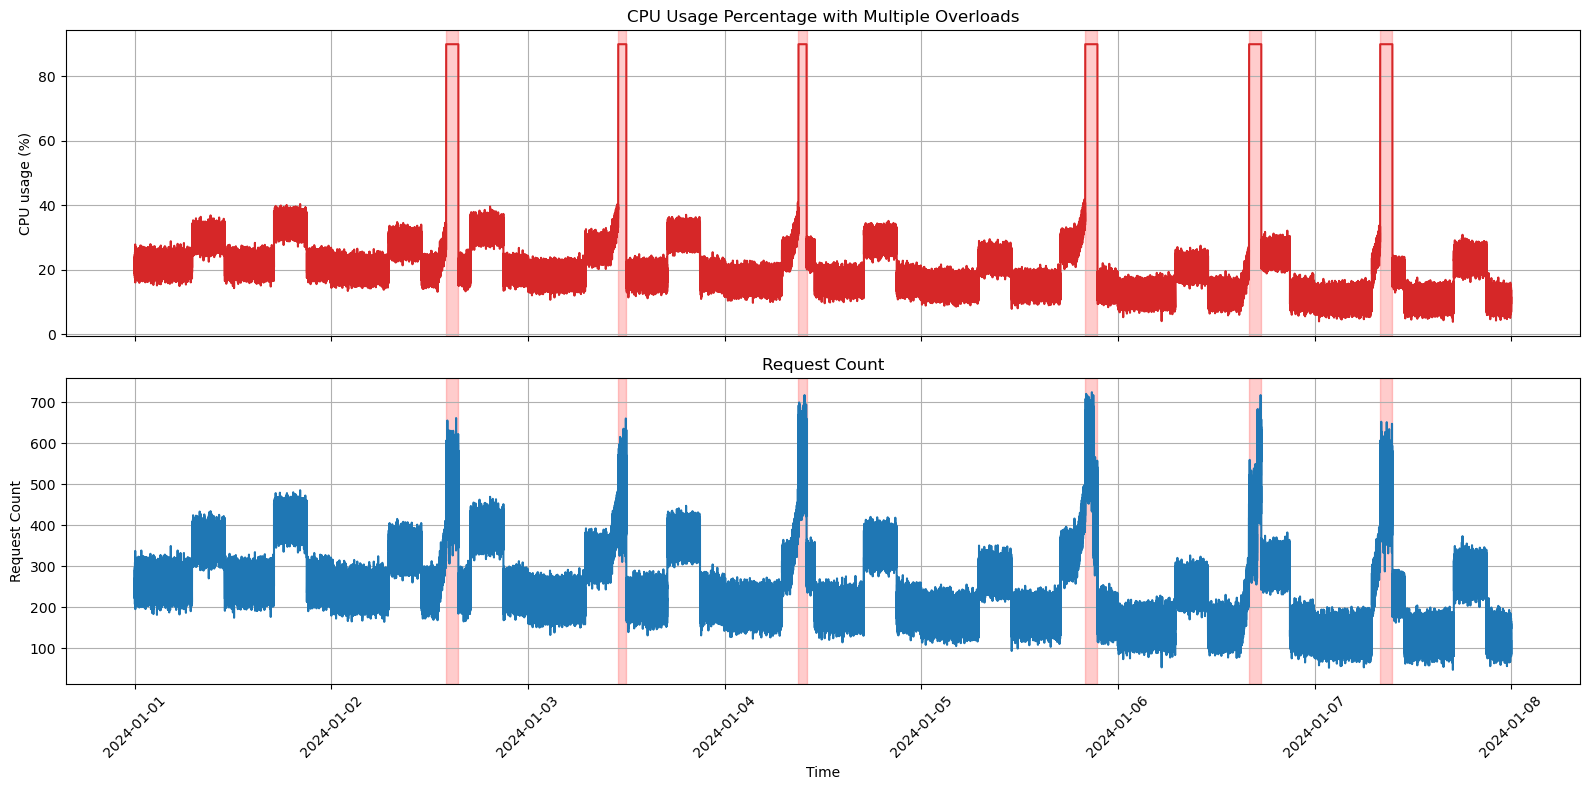

In [8]:
# Vẽ đồ thị CPU usage % và Request Count để thấy rõ spike overload
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

axs[0].plot(df["Timestamp"], df["CPU usage [%]"], color="tab:red")
axs[0].set_ylabel("CPU usage (%)")
axs[0].set_title("CPU Usage Percentage with Multiple Overloads")
axs[0].grid(True)

axs[1].plot(df["Timestamp"], df["Request Count"], color="tab:blue")
axs[1].set_ylabel("Request Count")
axs[1].set_title("Request Count")
axs[1].set_xlabel("Time")
axs[1].grid(True)

for start, end in overload_periods:
    axs[0].axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.2)
    axs[1].axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.2)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
df.drop(columns=["Hour", "Weekday", "HourBoost", "WeekdayBoost", "Noise", "Spike"], inplace=True)

In [4]:
df["Memory capacity provisioned [KB]"] = df["Memory capacity provisioned [KB]"] / 48

In [5]:
len(df)

604800

In [13]:
df.to_csv("../../data/mock-metrics/2.csv", sep=";")